In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from tensorflow_probability.python.math.psd_kernels.internal import util
from typing import List

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"


In [2]:
import arviz as az

az.style.use("arviz-viridish")


In [3]:
cd ..

/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp


In [4]:
from multi_fidelity_tensorflow.data_loader import PowerSpecsMFBox as PowerSpecs
from multi_fidelity_tensorflow.data_loader import interpolate


In [5]:
np.random.seed(20)


## Prepare Power Spectrum data

Power spectrum, P(k), is the Fourier Transform of the correlation function in the Universe. It describes the variance of the matter density field as a function of k. k is in unit of inverse length, which means small k describes longer distances and large k describes shorter distances. Thus, large P(k) at large k means there are more structures (more variance) at the large scales (longer distances).

Below, we use the power spectrum from dark-matter only simulations.


L1: Large box, low res  
L2: Small box, low res


In [6]:
# This is only redshift zero
def generate_data(
    folder_1: str = "data/processed/Matterpower_60_res128box256_3_res512box256_z0_ind-0-1-2/",
    folder_2: str = "data/processed/Matterpower_60_res128box100_3_res512box256_z0_ind-0-1-2/",
    n_fidelities: int = 2,
):
    data_1 = PowerSpecs(
        n_fidelities=n_fidelities,
    )
    data_1.read_from_txt(folder=folder_1)

    data_2 = PowerSpecs(
        n_fidelities=n_fidelities,
    )
    data_2.read_from_txt(folder=folder_2)

    return data_1, data_2


In [7]:
data_1, data_2 = generate_data()


In [8]:
# This is a step to interpolate power spectra from L1 and L2
# to the k bins of HF power spectrum.
# The interpolation is find because L1 and L2 are approximation of HF anyway,
# adding interpolation step is just another approximation.
# However, an alternative way is to re-write the binning code to bin everything into
# the same k bins. I did not do that because I think the approach here is more
# generalizable.

# highres: log10_ks; lowres: log10_k
# we are emulating data_1's highres
log10_k_target = data_1.kf
log10_k_train = data_2.kf
ind_min = (log10_k_target >= log10_k_train.min()) & (
    log10_k_target <= log10_k_train.max()
)
# interpolate: interp(log10_k, Y_lf)(log10_k[ind_min])
data_2.Y_train_norm[0] = interpolate(
    data_2.kf, data_2.Y_train_norm[0], data_1.kf[ind_min]
)
data_2.Y_train[0] = interpolate(data_2.kf, data_2.Y_train[0], data_1.kf[ind_min])
assert data_2.Y_train_norm[0].shape[1] == data_1.kf[ind_min].shape[0]
# HF powerspecs trim to same size as LF
data_1.Y_train_norm[0] = data_1.Y_train_norm[0][:, ind_min]
data_1.Y_train[0] = data_1.Y_train[0][:, ind_min]
data_1.Y_train_norm[1] = data_1.Y_train_norm[1][:, ind_min]
data_1.Y_train[1] = data_1.Y_train[1][:, ind_min]

data_1.Y_test[0] = data_1.Y_test[0][:, ind_min]

kf = data_1.kf[ind_min]
data_1.kf = kf
data_2.kf = kf


95 117 117
[Info] rebin powerspecs from 117 k bins to 95 k bins.
95 117 117
[Info] rebin powerspecs from 117 k bins to 95 k bins.


In [9]:
# Fourier k modes
kf = data_1.kf

# X is the input cosmological parameters, (Omega_m, Omega_0, h, A_s, n_s)
X_l1 = data_1.X_train_norm[0]
X_l2 = data_2.X_train_norm[0]

X_h = data_1.X_train_norm[1]
# lower and upper bounds (prior volume) of the cosmological parameters
param_limits = data_1.parameter_limits

# Y is the power spectrum, P(k)
Y_l1 = data_1.Y_train[0]
Y_l2 = data_2.Y_train[0]
Y_h = data_1.Y_train[1]

# Test set
X_test = data_1.X_test_norm[0]
Y_test = data_1.Y_test[0]


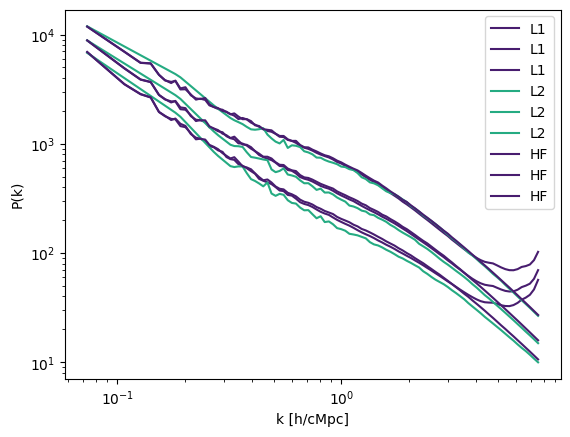

In [10]:
plt.loglog(10**kf, 10 ** Y_l1[:3, :].T, color="C0", label="L1")
plt.loglog(10**kf, 10 ** Y_l2[:3, :].T, color="C2", label="L2")
plt.loglog(10**kf, 10 ** Y_h[:3, :].T, color="C5", label="HF")

plt.xlabel("k [h/cMpc]")
plt.ylabel("P(k)")
plt.legend()


Normalizing using mean at HF indeed introduce some bias at small scales (towards negative).

Not normalizing has no issue of that, but the emulator error the amplitude is still high.

- Interesting point: It's because the mean at HF is not at the center of the parameter space,
  and it's not the same parameter point as the LF. There will be some mismatch between LF and HF,
  then making it hard to train. Not totally sure if I will introduce bias or not.


In [11]:
# [L1 fidelity]
# Normalized: Here we substract the P(k) with its mean at a certain k,
# P(k= k') <- P(k= k') - Mean(P(k = k'))
Y_l1_mean = np.mean(Y_l1, axis=0)
_Y_l1_old = Y_l1
Y_l1 = Y_l1 - Y_l1_mean

# [L1 fidelity]
# Normalized: Here we substract the P(k) with its mean at a certain k,
# P(k= k') <- P(k= k') - Mean(P(k = k'))
Y_l2_mean = np.mean(Y_l2, axis=0)
_Y_l2_old = Y_l2
Y_l2 = Y_l2 - Y_l2_mean

# [H fidelity]
# Y_h_mean = np.mean(Y_h, axis=0)
_Y_h_old = Y_h
Y_h = Y_h  # - Y_h_mean

# [Test H fidelity]
_Y_test_old = Y_test
Y_test = Y_test  # - Y_h_mean

# The transpose here is to fit the convention of tensorflow, which wants Y in dimension of
# (num of outputs, num of examples)
Y_l1 = Y_l1.T
Y_l2 = Y_l2.T
Y_h = Y_h.T
Y_test = Y_test.T


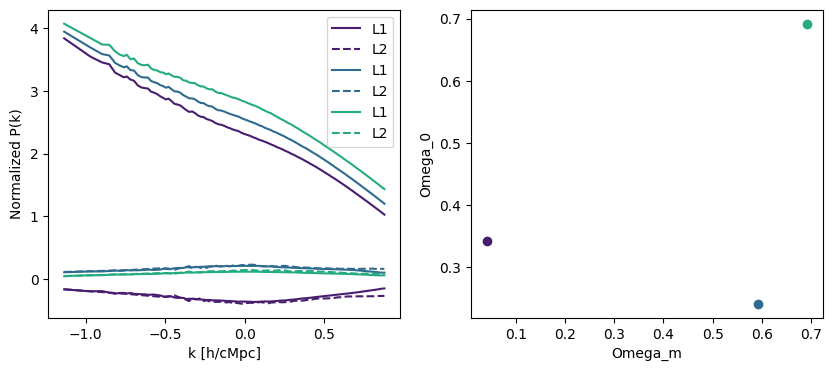

In [12]:
# preview the first 4 simulations
# also plot the input parameters in ith and jth dimension

#### Changable: Choice of two-dim projection of parameters ####
param_i = 0  # choose 0 ~ 8
param_j = 1  # choose 0 ~ 8
###############################################################

param_names = ["Omega_m", "Omega_0", "h", "A_s", "n_s"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for k in range(3):
    ax[0].plot(
        kf,
        Y_l1[:, 57 + k],
        color="C{}".format(k),
        label="L1",
    )
    ax[0].plot(kf, Y_l2[:, 57 + k], color="C{}".format(k), label="L2", ls="--")

    # view the input X with the corresponding colors
    ax[1].plot(
        X_l1[57 + k, param_i],
        X_l1[57 + k, param_j],
        ls="",
        marker="o",
        color="C{}".format(k),
    )

    ax[0].plot(
        kf,
        Y_h[:, k],
        color="C{}".format(k),
    )


ax[0].set_xlabel("k [h/cMpc]")
ax[0].set_ylabel("Normalized P(k)")

ax[1].set_xlabel(param_names[param_i])
ax[1].set_ylabel(param_names[param_j])

ax[0].legend()


In [13]:
# the convention of tensorflow:
#  number_examples : number of training simulations
#  number_features : number of parameters you have in input space
#  number_outputs  : number of bins you have in output space
num_examples_l1, num_features_l1 = X_l1.shape
num_outputs_l1, num_examples_l1 = Y_l1.shape

print("L1", num_examples_l1, num_features_l1, num_outputs_l1)

num_examples_l2, num_features_l2 = X_l2.shape
num_outputs_l2, num_examples_l2 = Y_l2.shape

print("L2", num_examples_l2, num_features_l2, num_outputs_l2)

num_examples_h, num_features_h = X_h.shape
num_outputs_h, num_examples_h = Y_h.shape

print("HF", num_examples_h, num_features_h, num_outputs_h)


L1 60 5 95
L2 60 5 95
HF 3 5 95


## Build your GP with TensorFlow

We want our GP to have different hyperparameters for different feature dimensions. There are 9 dimensions in the input space, and we want our GP's covariance function behaves differently in a different dimension.

Assigning different hyperparameters for each dimension is also called Automatic Relevance Determination (ARD) in the GP community. If we use a standard Exponiated Quadratic (also called Radial Basis or Squared Exponential) kernel, ARD will assign one lengthscale per feature dimension (9 lengthscales in our case).

ARD can be applied through [`FeatureScaled`](https://www.tensorflow.org/probability/api_docs/python/tfp/math/psd_kernels/FeatureScaled) kernel in Tensflow probability.

```python
tfp.math.psd_kernels.FeatureScaled(
 kernel,
 scale_diag=None,
 inverse_scale_diag=None,
 validate_args=False,
 name='FeatureScaled'
)
```

> Given a kernel `K` and `scale_diag` and inputs `x` and `x'`, this kernel first rescales the input by computing `x / scale_diag` and `x' / scale_diag`, and passing this to `K`.

$$
K ← K(\frac{x}{\lambda}, \frac{x'}{\lambda})
$$


### Choose your kernels

As mentioned before, the outcomes of the simulation code are assumed to be sampled from an emulator, $f$:

$$
f \sim \mathrm{GaussianProcess}\left(0, \mathrm{covariance\_fn}=k(x, x')\right).
$$

The only thing left to be learned from the training set is the covariance function, $k(x, x')$.

Here we choose the most common GP kernel, ExponentiatedQuadratic (also called Radial Basis or Gaussian kernel) covariance kernel:

$$
k(x, x') = \sigma^2 \exp \left( \frac{\|x - x'\|^2}{\lambda^2} \right),
$$

- $\sigma^2$: the variance, it is called **amplitude** in TFP.
- $\lambda$: the lengthscale.


## Multi-fidelity with Non-linear Autoregressive Model

We could define a new kernel class to incorporate two kernels


Here we build two GPs, while passing the 1st GP's output to the second GP.


In [14]:
class ActiveDimension(tfk.FeatureTransformed):
    def __init__(
        self,
        kernel,
        active_dim: List,
        validate_args=False,
        parameters=None,
        name="ActiveDim",
    ) -> None:
        self._transformation_fn = (
            lambda x, feature_ndims, param_expansion_ndims: tf.gather(
                x,
                active_dim,
                axis=-1,
            )
        )

        super(ActiveDimension, self).__init__(
            kernel=kernel,
            transformation_fn=self._transformation_fn,
            validate_args=validate_args,
            parameters=parameters,
            name=name,
        )

        # Keep the kernel so that we can get the batch shape
        self._kernel = kernel

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor


In [15]:
n_input_dims = num_features_h
# although we have multiple bins, bins should be in num_outputs dim, not features
n_output_dim = 1
base_dims_list = list(range(n_input_dims))
l1_out_dims_list = list(range(n_input_dims, n_input_dims + n_output_dim))
l2_out_dims_list = list(
    range(n_input_dims + n_output_dim, n_input_dims + n_output_dim + n_output_dim)
)
l1_l2_out_dims_list = list(range(n_input_dims, n_input_dims + 2 * n_output_dim))

base_dims_list, l1_out_dims_list, l2_out_dims_list, l1_l2_out_dims_list


([0, 1, 2, 3, 4], [5], [6], [5, 6])

In [16]:
def get_lf_kernel(amplitude, length_scale):
    """
    SE kernel with ARD
    """
    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    se_kernel = tfk.ExponentiatedQuadratic(amplitude)
    # this is our ARD kernel, with 1 lengthscale per feature dim.
    # we use scale_diag to represent the lengthscales.
    kernel = tfk.FeatureScaled(
        se_kernel,
        scale_diag=length_scale,
    )

    return kernel


def get_mfbox_kernel(
    scale_amplitude_l1_0,  # HF
    scale_length_scale_l1_0,  # HF
    scale_amplitude_l2_0,  # HF
    scale_length_scale_l2_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    linear_bias_amplitude_0,  # HF
    linear_slope_amplitude_0,  # HF
    linear_shift_0,
):
    # HF kernel
    scale_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(scale_amplitude_l1_0, scale_length_scale_l1_0),
        active_dim=l1_out_dims_list,
    )
    scale_kernel *= ActiveDimension(
        tfk.ExponentiatedQuadratic(scale_amplitude_l2_0, scale_length_scale_l2_0),
        active_dim=l2_out_dims_list,
    )
    scale_kernel += ActiveDimension(
        tfk.Linear(
            bias_amplitude=linear_bias_amplitude_0,
            slope_amplitude=linear_slope_amplitude_0,
            shift=linear_shift_0,
        ),
        active_dim=l1_l2_out_dims_list,
    )
    # scale_kernel += ActiveDimension(
    #     tfk.Linear(
    #         bias_amplitude=None,
    #         slope_amplitude=linear_slope_amplitude_0,
    #         shift=None,
    #     ),
    #     active_dim=out_dims_list,
    # )
    interaction_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(interaction_amplitude_0, interaction_length_scale_0),
        active_dim=base_dims_list,
    )
    bias_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(bias_amplitude_0, bias_length_scale_0),
        active_dim=base_dims_list,
    )
    # MFBox kernel
    kernel_h = interaction_kernel * scale_kernel + bias_kernel

    return kernel_h


In [17]:
def make_mfbox_index_points(m1, m2, X_h, num_outputs_h):
    # Index points for H include [X, mean from L1]
    # ---
    # Shape : [num_examples_h, num_features_h]
    ## -> [num_outputs, num_examples_h, num_features_h]
    _x_h_repeat = tf.repeat(X_h[None, :, :], num_outputs_h, axis=0)
    # Shape : [num_outputs, num_examples_h]
    ## -> [num_outputs, num_examples_h, 1]
    _m1 = m1[:, :, None]
    # Shape : [num_outputs, num_examples_h]
    ## -> [num_outputs, num_examples_h, 1]
    _m2 = m2[:, :, None]
    # Index point for NARGP
    index_points_h = tf.concat([_x_h_repeat, _m1, _m2], axis=2)
    return index_points_h


In [18]:
def build_gp_l1(amplitude, length_scale, observation_noise_variance):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """
    kernel = get_lf_kernel(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X_l1,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


def build_gp_l2(amplitude, length_scale, observation_noise_variance):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """
    kernel = get_lf_kernel(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=X_l2,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


def build_gp_mfbox(
    scale_amplitude_l1_0,  # HF
    scale_length_scale_l1_0,  # HF
    scale_amplitude_l2_0,  # HF
    scale_length_scale_l2_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    linear_bias_amplitude_0,  # HF
    linear_slope_amplitude_0,  # HF
    linear_shift_0,
    amplitude_1,  # L1
    length_scale_1,  # L1
    amplitude_2,  # L2
    length_scale_2,  # L2
    observation_noise_variance_0,
    observation_noise_variance_1,  # L1
    observation_noise_variance_2,  # L2
):
    """
    High-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    f_HF = \rho f_LF + \delta

      X_HF -> GP_LF -> f_LF
      X_HF -> GP_HF -> delta_HF
                  -> f_LF * rho + delta_HF
    """
    kernel_h = get_mfbox_kernel(
        scale_amplitude_l1_0,  # HF
        scale_length_scale_l1_0,  # HF
        scale_amplitude_l2_0,  # HF
        scale_length_scale_l2_0,  # HF
        interaction_amplitude_0,  # HF
        interaction_length_scale_0,  # HF
        bias_amplitude_0,  # HF
        bias_length_scale_0,  # HF
        linear_bias_amplitude_0,  # HF
        linear_slope_amplitude_0,  # HF
        linear_shift_0,
    )
    # L1 kernel
    kernel_l1 = get_lf_kernel(amplitude_1, length_scale_1)
    # L2 kernel
    kernel_l2 = get_lf_kernel(amplitude_2, length_scale_2)

    ## [L1 Predictions]
    ## Mean predictions from the LF GP
    gprm_l1 = tfd.GaussianProcessRegressionModel(
        kernel=kernel_l2,
        index_points=X_h,
        observation_index_points=X_l1,
        observations=Y_l1,
        observation_noise_variance=observation_noise_variance_1,
        predictive_noise_variance=0.0,
    )
    # Shape: [num_outputs, num_examples(index points)]
    m1 = gprm_l1.mean()

    ## [L2 Predictions]
    ## Mean predictions from the LF GP
    gprm_l2 = tfd.GaussianProcessRegressionModel(
        kernel=kernel_l2,
        index_points=X_h,
        observation_index_points=X_l2,
        observations=Y_l2,
        observation_noise_variance=observation_noise_variance_2,
        predictive_noise_variance=0.0,
    )
    # Shape: [num_outputs, num_examples(index points)]
    m2 = gprm_l2.mean()

    # Index points for H include [X, mean from L1]
    index_points_h = make_mfbox_index_points(m1, m2, X_h, num_outputs_h)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel_h,
        index_points=index_points_h,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance_0,
    )


### Priors


Uniform priors


In [19]:
# ## L1
# gp_joint_model_l1 = tfd.JointDistributionNamed(
#     {
#         "amplitude": tfd.Uniform(
#             low=np.ones([num_outputs_l1]) * 1e-6,
#             high=np.ones([num_outputs_l1]) * 1e3,
#         ),
#         "length_scale": tfd.Independent(
#             tfd.Uniform(
#                 low=np.ones([num_outputs_l1, num_features_l1]) * 1e-6,
#                 high=np.ones([num_outputs_l1, num_features_l1]) * 1e7,
#             ),
#             reinterpreted_batch_ndims=1,
#         ),
#         "observation_noise_variance": tfd.Uniform(
#             low=np.ones([num_outputs_l1]) * 1e-15,
#             high=np.ones([num_outputs_l1]) * 1e-2,
#         ),
#         "observations": build_gp_l1,
#     }
# )
# ## L2
# gp_joint_model_l2 = tfd.JointDistributionNamed(
#     {
#         "amplitude": tfd.Uniform(
#             low=np.ones([num_outputs_l2]) * 1e-6,
#             high=np.ones([num_outputs_l2]) * 1e3,
#         ),
#         "length_scale": tfd.Independent(
#             tfd.Uniform(
#                 low=np.ones([num_outputs_l2, num_features_l2]) * 1e-6,
#                 high=np.ones([num_outputs_l2, num_features_l2]) * 1e7,
#             ),
#             reinterpreted_batch_ndims=1,
#         ),
#         "observation_noise_variance": tfd.Uniform(
#             low=np.ones([num_outputs_l2]) * 1e-15,
#             high=np.ones([num_outputs_l2]) * 1e-2,
#         ),
#         "observations": build_gp_l2,
#     }
# )

# ## HF
# gp_joint_model_hf = tfd.JointDistributionNamed(
#     {
#         "scale_amplitude_l1_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "scale_length_scale_l1_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "scale_amplitude_l2_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "scale_length_scale_l2_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "interaction_amplitude_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "interaction_length_scale_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "bias_amplitude_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "bias_length_scale_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),
#         "linear_bias_amplitude_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),  # linear
#         "linear_slope_amplitude_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-9,
#             high=np.ones([num_outputs_h]) * 1e9,
#         ),  # linear
#         "linear_shift_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * -10, high=np.ones([num_outputs_h]) * 10
#         ),  # linear
#         "amplitude_1": tfd.Uniform(
#             low=np.ones([num_outputs_l1]) * 1e-9,
#             high=np.ones([num_outputs_l1]) * 1e9,
#         ),
#         "length_scale_1": tfd.Independent(
#             tfd.Uniform(
#                 low=np.ones([num_outputs_l1, num_features_l1]) * 1e-9,
#                 high=np.ones([num_outputs_l1, num_features_l1]) * 1e9,
#             ),
#             reinterpreted_batch_ndims=1,
#         ),
#         "amplitude_2": tfd.Uniform(
#             low=np.ones([num_outputs_l2]) * 1e-9,
#             high=np.ones([num_outputs_l2]) * 1e9,
#         ),
#         "length_scale_2": tfd.Independent(
#             tfd.Uniform(
#                 low=np.ones([num_outputs_l2, num_features_l2]) * 1e-9,
#                 high=np.ones([num_outputs_l2, num_features_l2]) * 1e9,
#             ),
#             reinterpreted_batch_ndims=1,
#         ),
#         "observation_noise_variance_1": tfd.Uniform(
#             low=np.ones([num_outputs_l1]) * 1e-15,
#             high=np.ones([num_outputs_l1]) * 1e-2,
#         ),
#         "observation_noise_variance_2": tfd.Uniform(
#             low=np.ones([num_outputs_l2]) * 1e-15,
#             high=np.ones([num_outputs_l2]) * 1e-2,
#         ),
#         "observation_noise_variance_0": tfd.Uniform(
#             low=np.ones([num_outputs_h]) * 1e-15,
#             high=np.ones([num_outputs_h]) * 1e-2,
#         ),
#         "observations": build_gp_mfbox,
#     }
# )


LogNormal prior (Weakly informative)


In [20]:
## L1
# Amplitude closes to zero meaning not important
# Lengthscale close to infinity meaning not important

amplitude_loc = 0
amplitude_scale = 8
lengthscale_loc = 1
lengthscale_scale = 8

interaction_amplitude_loc = 0
interaction_amplitude_scale = 10
interaction_lengthscale_loc = 10
interaction_lengthscale_scale = 3

gp_joint_model_l1 = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(
            loc=np.ones([num_outputs_l1]) * amplitude_loc,
            scale=np.ones([num_outputs_l1]) * amplitude_scale,
        ),
        "length_scale": tfd.Independent(
            tfd.LogNormal(
                loc=np.ones([num_outputs_l1, num_features_l1]) * lengthscale_loc,
                scale=np.ones([num_outputs_l1, num_features_l1]) * lengthscale_scale,
            ),
            reinterpreted_batch_ndims=1,
        ),
        "observation_noise_variance": tfd.Uniform(
            low=np.ones([num_outputs_l1]) * 1e-15,
            high=np.ones([num_outputs_l1]) * 1e-2,
        ),
        "observations": build_gp_l1,
    }
)
## L2
gp_joint_model_l2 = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(
            loc=np.ones([num_outputs_l2]) * amplitude_loc,
            scale=np.ones([num_outputs_l2]) * amplitude_scale,
        ),
        "length_scale": tfd.Independent(
            tfd.LogNormal(
                loc=np.ones([num_outputs_l2, num_features_l2]) * lengthscale_loc,
                scale=np.ones([num_outputs_l2, num_features_l2]) * lengthscale_scale,
            ),
            reinterpreted_batch_ndims=1,
        ),
        "observation_noise_variance": tfd.Uniform(
            low=np.ones([num_outputs_l2]) * 1e-15,
            high=np.ones([num_outputs_l2]) * 1e-2,
        ),
        "observations": build_gp_l2,
    }
)

## HF
gp_joint_model_hf = tfd.JointDistributionNamed(
    {
        "scale_amplitude_l1_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * amplitude_loc,
            scale=np.ones([num_outputs_h]) * amplitude_scale,
        ),
        "scale_length_scale_l1_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * lengthscale_loc,
            scale=np.ones([num_outputs_h]) * lengthscale_scale,
        ),
        "scale_amplitude_l2_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * amplitude_loc,
            scale=np.ones([num_outputs_h]) * amplitude_scale,
        ),
        "scale_length_scale_l2_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * lengthscale_loc,
            scale=np.ones([num_outputs_h]) * lengthscale_scale,
        ),
        "interaction_amplitude_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * interaction_amplitude_loc,
            scale=np.ones([num_outputs_h]) * interaction_amplitude_scale,
        ),
        "interaction_length_scale_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * interaction_lengthscale_loc,
            scale=np.ones([num_outputs_h]) * interaction_lengthscale_scale,
        ),
        "bias_amplitude_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * amplitude_loc,
            scale=np.ones([num_outputs_h]) * amplitude_scale,
        ),
        "bias_length_scale_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * lengthscale_loc,
            scale=np.ones([num_outputs_h]) * lengthscale_scale,
        ),
        "linear_bias_amplitude_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * amplitude_loc,
            scale=np.ones([num_outputs_h]) * amplitude_scale,
        ),  # linear
        "linear_slope_amplitude_0": tfd.LogNormal(
            loc=np.ones([num_outputs_h]) * amplitude_loc,
            scale=np.ones([num_outputs_h]) * amplitude_scale,
        ),  # linear
        "linear_shift_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * -10,
            high=np.ones([num_outputs_h]) * 10,
        ),  # linear
        "amplitude_1": tfd.LogNormal(
            loc=np.ones([num_outputs_l1]) * amplitude_loc,
            scale=np.ones([num_outputs_l1]) * amplitude_scale,
        ),
        "length_scale_1": tfd.Independent(
            tfd.LogNormal(
                loc=np.ones([num_outputs_l1, num_features_l1]) * lengthscale_loc,
                scale=np.ones([num_outputs_l1, num_features_l1]) * lengthscale_scale,
            ),
            reinterpreted_batch_ndims=1,
        ),
        "amplitude_2": tfd.LogNormal(
            loc=np.ones([num_outputs_l2]) * amplitude_loc,
            scale=np.ones([num_outputs_l2]) * amplitude_scale,
        ),
        "length_scale_2": tfd.Independent(
            tfd.LogNormal(
                loc=np.ones([num_outputs_l2, num_features_l2]) * lengthscale_loc,
                scale=np.ones([num_outputs_l2, num_features_l2]) * lengthscale_scale,
            ),
            reinterpreted_batch_ndims=1,
        ),
        "observation_noise_variance_1": tfd.Uniform(
            low=np.ones([num_outputs_l1]) * 1e-15,
            high=np.ones([num_outputs_l1]) * 1e-2,
        ),
        "observation_noise_variance_2": tfd.Uniform(
            low=np.ones([num_outputs_l2]) * 1e-15,
            high=np.ones([num_outputs_l2]) * 1e-2,
        ),
        "observation_noise_variance_0": tfd.Uniform(
            low=np.ones([num_outputs_h]) * 1e-15,
            high=np.ones([num_outputs_h]) * 1e-2,
        ),
        "observations": build_gp_mfbox,
    }
)


In [21]:
# Test the batch shape
gp_joint_model_l1.batch_shape, gp_joint_model_l2.batch_shape, gp_joint_model_hf.batch_shape


Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcess` evaluated at asingle index point now always has event shape `[1]` (the previous behaviorfor `always_yield_multivariate_normal=True`). To reproduce the previous behavior of `always_yield_multivariate_normal=False`, squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcessRegressionModel`evaluated at a single index point now always has event shape `[1]` (theprevious behavior for `always_yield_multivariate_normal=True`). Toreproduce the previous behavior of`always_yield_multivariate_normal=False`, squeeze the rightmost singletondimension from the output of `mean`, `samp

({'observation_noise_variance': TensorShape([95]),
  'length_scale': TensorShape([95]),
  'amplitude': TensorShape([95]),
  'observations': TensorShape([95])},
 {'observation_noise_variance': TensorShape([95]),
  'length_scale': TensorShape([95]),
  'amplitude': TensorShape([95]),
  'observations': TensorShape([95])},
 {'scale_length_scale_l2_0': TensorShape([95]),
  'scale_length_scale_l1_0': TensorShape([95]),
  'scale_amplitude_l2_0': TensorShape([95]),
  'scale_amplitude_l1_0': TensorShape([95]),
  'observation_noise_variance_2': TensorShape([95]),
  'observation_noise_variance_1': TensorShape([95]),
  'observation_noise_variance_0': TensorShape([95]),
  'linear_slope_amplitude_0': TensorShape([95]),
  'linear_shift_0': TensorShape([95]),
  'linear_bias_amplitude_0': TensorShape([95]),
  'length_scale_2': TensorShape([95]),
  'length_scale_1': TensorShape([95]),
  'interaction_length_scale_0': TensorShape([95]),
  'interaction_amplitude_0': TensorShape([95]),
  'bias_length_scale_0

Set the learnable parameters and train based on the maximum marginal likelihoods of two GPs.


In [22]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
# jibancat: the scale parameter no needs to be positive,
# but I guess it's okay to constrain it to be positive so the delta would
# compensate the sign difference.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

identity = tfb.Identity()

# HF parameters
scale_amplitude_l1_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="scale_amplitude_l1_0",
    dtype=np.float64,
)
scale_length_scale_l1_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="scale_length_scale_l1_0",
    dtype=np.float64,
)
scale_amplitude_l2_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="scale_amplitude_l2_0",
    dtype=np.float64,
)
scale_length_scale_l2_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="scale_length_scale_l2_0",
    dtype=np.float64,
)
interaction_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="interaction_amplitude_0",
    dtype=np.float64,
)
interaction_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="interaction_length_scale_0",
    dtype=np.float64,
)
bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="bias_amplitude_0",
    dtype=np.float64,
)
bias_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="bias_length_scale_0",
    dtype=np.float64,
)

# Linear kernel
linear_bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="linear_bias_amplitude_0",
    dtype=np.float64,
)
linear_slope_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]),
    bijector=constrain_positive,
    name="linear_slope_amplitude_0",
    dtype=np.float64,
)
linear_shift_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]) * 0.0,
    bijector=identity,
    name="linear_shift_0",
    dtype=np.float64,
)

# Noise
observation_noise_variance_var_0 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_h]) * 1e-7,
    bijector=constrain_positive,
    name="observation_noise_variance_var_0",
    dtype=np.float64,
)

# L1 parameters
amplitude_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l1]),
    bijector=constrain_positive,
    name="amplitude_1",
    dtype=np.float64,
)

length_scale_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l1, num_features_l1]),
    bijector=constrain_positive,
    name="length_scale_1",
    dtype=np.float64,
)

observation_noise_variance_var_1 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l1]) * 1e-7,
    bijector=constrain_positive,
    name="observation_noise_variance_var_1",
    dtype=np.float64,
)


# L2 parameters
amplitude_var_2 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l2]),
    bijector=constrain_positive,
    name="amplitude_2",
    dtype=np.float64,
)

length_scale_var_2 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l2, num_features_l2]),
    bijector=constrain_positive,
    name="length_scale_2",
    dtype=np.float64,
)

observation_noise_variance_var_2 = tfp.util.TransformedVariable(
    initial_value=np.ones([num_outputs_l2]) * 1e-7,
    bijector=constrain_positive,
    name="observation_noise_variance_var_2",
    dtype=np.float64,
)

# [L1 only]
trainable_variables_L1 = [
    v.trainable_variables[0]
    for v in [
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
    ]
]
# [L2 only]
trainable_variables_L2 = [
    v.trainable_variables[0]
    for v in [
        amplitude_var_2,
        length_scale_var_2,
        observation_noise_variance_var_2,
    ]
]

# [LF only]
trainable_variables_LF = [
    v.trainable_variables[0]
    for v in [
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
        amplitude_var_2,
        length_scale_var_2,
        observation_noise_variance_var_2,
    ]
]


# [MFBox only]
trainable_variables_MFBox = [
    v.trainable_variables[0]
    for v in [
        scale_amplitude_l1_var_0,
        scale_length_scale_l1_var_0,
        scale_amplitude_l2_var_0,
        scale_length_scale_l2_var_0,
        interaction_amplitude_var_0,
        interaction_length_scale_var_0,
        bias_amplitude_var_0,
        bias_length_scale_var_0,
        observation_noise_variance_var_0,
        linear_bias_amplitude_var_0,
        linear_slope_amplitude_var_0,
        linear_shift_var_0,
    ]
]


To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

We will combine the log likelihoods from both GP_LF and GP_HF to be one joint likelihood.


In [23]:
def target_log_prob_LF(
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
    amplitude_2,
    length_scale_2,
    observation_noise_variance_2,
):
    """
    Loglike(L1) + Loglike(L2)
    """

    log_prob_l1 = gp_joint_model_l1.log_prob(
        {
            "amplitude": amplitude_1,
            "length_scale": length_scale_1,
            "observation_noise_variance": observation_noise_variance_1,
            "observations": Y_l1,
        }
    )
    log_prob_l1 = tf.reduce_sum(log_prob_l1)

    log_prob_l2 = gp_joint_model_l2.log_prob(
        {
            "amplitude": amplitude_2,
            "length_scale": length_scale_2,
            "observation_noise_variance": observation_noise_variance_2,
            "observations": Y_l2,
        }
    )
    log_prob_l2 = tf.reduce_sum(log_prob_l2)

    return log_prob_l1 + log_prob_l2


In [24]:
def target_log_prob(
    scale_amplitude_l1_0,  # HF
    scale_length_scale_l1_0,  # HF
    scale_amplitude_l2_0,  # HF
    scale_length_scale_l2_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    observation_noise_variance_0,
    linear_bias_amplitude_0,
    linear_slope_amplitude_0,
    linear_shift_0,
    amplitude_1,
    length_scale_1,
    amplitude_2,
    length_scale_2,
    observation_noise_variance_1,
    observation_noise_variance_2,
):
    """
    Loglike(HF)
    """

    # log_prob_lf = gp_joint_model_lf.log_prob(
    #     {
    #         "amplitude": amplitude_1,
    #         "length_scale": length_scale_1,
    #         "observation_noise_variance": observation_noise_variance_1,
    #         "observations": Y_l,
    #     }
    # )
    # log_prob_lf = tf.reduce_sum(log_prob_lf)

    log_prob_hf = gp_joint_model_hf.log_prob(
        {
            "scale_amplitude_l1_0": scale_amplitude_l1_0,
            "scale_length_scale_l1_0": scale_length_scale_l1_0,
            "scale_amplitude_l2_0": scale_amplitude_l2_0,
            "scale_length_scale_l2_0": scale_length_scale_l2_0,
            "interaction_amplitude_0": interaction_amplitude_0,
            "interaction_length_scale_0": interaction_length_scale_0,
            "bias_amplitude_0": bias_amplitude_0,
            "bias_length_scale_0": bias_length_scale_0,
            "linear_bias_amplitude_0": linear_bias_amplitude_0,
            "linear_slope_amplitude_0": linear_slope_amplitude_0,
            "linear_shift_0": linear_shift_0,
            "amplitude_1": amplitude_1,
            "length_scale_1": length_scale_1,
            "amplitude_2": amplitude_2,
            "length_scale_2": length_scale_2,
            "observation_noise_variance_0": observation_noise_variance_0,
            "observation_noise_variance_1": observation_noise_variance_1,
            "observation_noise_variance_2": observation_noise_variance_2,
            "observations": Y_h,
        }
    )
    log_prob_hf = tf.reduce_sum(log_prob_hf)
    return log_prob_hf

    # return tf.reduce_sum([log_prob_hf, log_prob_lf])


To avoid the learnable Gaussian noise term dominates the training, fix the noise first
and then train the hyperparameters.


In [25]:
# Now we optimize the model parameters.
num_iters = 5000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-3)
# Two steps process: fix noise train GP -> relex noise train GP
fixed_noise = 1e-12


# [LF only] Fixed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_LFonly_fixed():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_LF(
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            amplitude_2=amplitude_var_2,
            length_scale_2=length_scale_var_2,
            # Noises are fixed here
            observation_noise_variance_1=fixed_noise,
            observation_noise_variance_2=fixed_noise,
        )
    grads = tape.gradient(loss, trainable_variables_LF)
    optimizer.apply_gradients(zip(grads, trainable_variables_LF))
    return loss


# [LF only] Fixed noise
lls_noise_lfonly_fixed = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_LFonly_fixed()
    lls_noise_lfonly_fixed[i] = loss


# Now we optimize the model parameters.
num_iters = 7500
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


# [LF only] Relaxed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_LFonly():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_LF(
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            amplitude_2=amplitude_var_2,
            length_scale_2=length_scale_var_2,
            # Noises are fixed here
            observation_noise_variance_1=observation_noise_variance_var_1,
            observation_noise_variance_2=observation_noise_variance_var_2,
        )
    grads = tape.gradient(loss, trainable_variables_LF)
    optimizer.apply_gradients(zip(grads, trainable_variables_LF))
    return loss


# [LF only] Relaxed noise
lls_noise_lfonly = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_LFonly()
    lls_noise_lfonly[i] = loss

# [Fix Low-fidelity node] Perdikaris et al.
# So the likelihood from the LF node is fixed.
## L1
fixed_noise_L1 = observation_noise_variance_var_1._value().numpy()
fixed_amplitude_1 = amplitude_var_1._value().numpy()
fixed_length_scale_1 = length_scale_var_1._value().numpy()
## L2
fixed_noise_L2 = observation_noise_variance_var_2._value().numpy()
fixed_amplitude_2 = amplitude_var_2._value().numpy()
fixed_length_scale_2 = length_scale_var_2._value().numpy()


# Now we optimize the model parameters.
num_iters = 7500
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)


# [NARGP only] Fixed noise
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model_MFBox_fixed():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_l1_0=scale_amplitude_l1_var_0,
            scale_length_scale_l1_0=scale_length_scale_l1_var_0,
            scale_amplitude_l2_0=scale_amplitude_l2_var_0,
            scale_length_scale_l2_0=scale_length_scale_l2_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=fixed_amplitude_1,
            length_scale_1=fixed_length_scale_1,
            amplitude_2=fixed_amplitude_2,
            length_scale_2=fixed_length_scale_2,
            observation_noise_variance_0=fixed_noise,
            observation_noise_variance_1=fixed_noise_L1,
            observation_noise_variance_2=fixed_noise_L2,
        )
    grads = tape.gradient(loss, trainable_variables_MFBox)
    optimizer.apply_gradients(zip(grads, trainable_variables_MFBox))
    return loss


# [MFBox only] Fixed noise
lls_noise_mfbox_fixed = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_MFBox_fixed()
    lls_noise_mfbox_fixed[i] = loss


# Now we optimize the model parameters.
num_iters = 7500
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=8e-3)


# [NARGP only] Fixed noise
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model_MFBox():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_l1_0=scale_amplitude_l1_var_0,
            scale_length_scale_l1_0=scale_length_scale_l1_var_0,
            scale_amplitude_l2_0=scale_amplitude_l2_var_0,
            scale_length_scale_l2_0=scale_length_scale_l2_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=fixed_amplitude_1,
            length_scale_1=fixed_length_scale_1,
            amplitude_2=fixed_amplitude_2,
            length_scale_2=fixed_length_scale_2,
            observation_noise_variance_0=observation_noise_variance_var_0,
            observation_noise_variance_1=fixed_noise_L1,
            observation_noise_variance_2=fixed_noise_L2,
        )
    grads = tape.gradient(loss, trainable_variables_MFBox)
    optimizer.apply_gradients(zip(grads, trainable_variables_MFBox))
    return loss


# [NARGP only] Relaxed noise
lls_noise_mfbox = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model_MFBox()
    lls_noise_mfbox[i] = loss


print("Trained parameters:")
print("L1 amplitude: {}".format(amplitude_var_1._value().numpy()))
print("L1 length_scale: {}".format(length_scale_var_1._value().numpy()))
print("L2 amplitude: {}".format(amplitude_var_2._value().numpy()))
print("L2 length_scale: {}".format(length_scale_var_2._value().numpy()))

print("HF scale l1 amplitude: {}".format(scale_amplitude_l1_var_0._value().numpy()))
print(
    "HF scale l1 length_scale: {}".format(scale_length_scale_l1_var_0._value().numpy())
)
print("HF scale l2 amplitude: {}".format(scale_amplitude_l2_var_0._value().numpy()))
print(
    "HF scale l2 length_scale: {}".format(scale_length_scale_l2_var_0._value().numpy())
)

print(
    "HF interaction amplitude: {}".format(interaction_amplitude_var_0._value().numpy())
)
print(
    "HF interaction length_scale: {}".format(
        interaction_length_scale_var_0._value().numpy()
    )
)
print("HF bias amplitude: {}".format(bias_amplitude_var_0._value().numpy()))
print("HF bias length_scale: {}".format(bias_length_scale_var_0._value().numpy()))

print("Linear kernel:")
print("----")
print(
    "HF linear bias amplitude: {}".format(linear_bias_amplitude_var_0._value().numpy())
)
print(
    "HF linear slope amplitude: {}".format(
        linear_slope_amplitude_var_0._value().numpy()
    )
)
print("HF linear shift: {}".format(linear_shift_var_0.numpy()))

print("Noise:")
print("----")
print(
    "HF observation_noise_variance: {}".format(
        observation_noise_variance_var_0._value().numpy()
    )
)
print(
    "L1 observation_noise_variance: {}".format(
        observation_noise_variance_var_1._value().numpy()
    )
)
print(
    "L2 observation_noise_variance: {}".format(
        observation_noise_variance_var_2._value().numpy()
    )
)


2023-09-11 19:08:53.474626: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
L1 amplitude: [0.58500966 0.70955438 0.77937546 0.76719635 0.76264399 0.84515303
 0.90195164 0.98070898 0.99125237 0.96191121 0.93131713 1.01956868
 1.05781912 1.15826652 1.15390267 1.13309071 1.1719687  1.20799254
 1.19680327 1.2134857  1.24681067 1.22090564 1.23731801 1.21107145
 1.20610447 1.22505293 1.072596   1.16750232 1.22826266 1.14249743
 1.04441358 1.02521892 1.14672596 0.98520207 1.10146791 0.99059282
 0.88907536 0.96886876 1.13689908 1.1744365  1.12877803 1.02032375
 1.02965016 1.07482932 1.09047441 1.15149728 0.97458508 1.04364353
 0.94429109 0.9460805  0.87313843 0.91687202 0.89927776 0.83645796
 0.82332045 0.82248139 0.81105375 0.84412907 0.91233674 0.88294186
 0.91937962 0.89873399 0.95560709 0.95388137 0.88979182 0.84555955
 0.80494125 0.78576189 0.80474008 0.79481646 0.72734296 0.7509182
 0.72304293 0.70732622 0.67901429 0.65434022 0.64428681 0.6250561
 0.59373566 0.57409492 0.54992976 0.51459159 0.4791314  0.45195981
 0.439943   0.43122208 0.38466

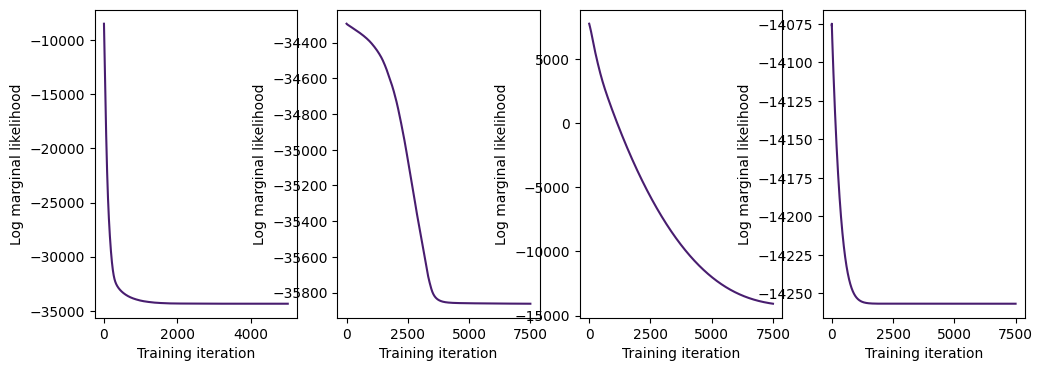

In [26]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].plot(lls_noise_lfonly_fixed)
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Log marginal likelihood")

ax[1].plot(lls_noise_lfonly)
ax[1].set_xlabel("Training iteration")
ax[1].set_ylabel("Log marginal likelihood")

ax[2].plot(lls_noise_mfbox_fixed)
ax[2].set_xlabel("Training iteration")
ax[2].set_ylabel("Log marginal likelihood")

ax[3].plot(lls_noise_mfbox)
ax[3].set_xlabel("Training iteration")
ax[3].set_ylabel("Log marginal likelihood")

plt.show()


In [27]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = X_test


# NARGP kernel
optimized_kernel_h = get_mfbox_kernel(
    scale_amplitude_l1_0=scale_amplitude_l1_var_0,
    scale_length_scale_l1_0=scale_length_scale_l1_var_0,
    scale_amplitude_l2_0=scale_amplitude_l2_var_0,
    scale_length_scale_l2_0=scale_length_scale_l2_var_0,
    interaction_amplitude_0=interaction_amplitude_var_0,
    interaction_length_scale_0=interaction_length_scale_var_0,
    bias_amplitude_0=bias_amplitude_var_0,
    bias_length_scale_0=bias_length_scale_var_0,
    linear_bias_amplitude_0=linear_bias_amplitude_var_0,
    linear_slope_amplitude_0=linear_slope_amplitude_var_0,
    linear_shift_0=linear_shift_var_0,
)

# L1 kernel
optimized_kernel_1 = get_lf_kernel(amplitude_var_1, length_scale_var_1)
# L2 kernel
optimized_kernel_2 = get_lf_kernel(amplitude_var_2, length_scale_var_2)

## Passing information from low-fidelity node
# L1 index points : Used in the train index for NARGP
index_optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=X_h,
    observation_index_points=X_l1,
    observations=Y_l1,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)
# L1 predictive points : Used in the predict index for NARGP
optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=X_l1,
    observations=Y_l1,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)
# L2 index points : Used in the train index for NARGP
index_optimized_gprm_l2 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_2,
    index_points=X_h,
    observation_index_points=X_l2,
    observations=Y_l2,
    observation_noise_variance=observation_noise_variance_var_2,
    predictive_noise_variance=np.float64(0.0),
)
# L2 predictive points : Used in the predict index for NARGP
optimized_gprm_l2 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_2,
    index_points=predictive_index_points_,
    observation_index_points=X_l2,
    observations=Y_l2,
    observation_noise_variance=observation_noise_variance_var_2,
    predictive_noise_variance=np.float64(0.0),
)


In [28]:
## Combine information
## Using Irene Ji's full covariance method
num_samples = 100
ntest = predictive_index_points_.shape[0]

# L1 Monte Carlo samples
index_m1 = index_optimized_gprm_l1.sample(num_samples)
m1 = optimized_gprm_l1.sample(num_samples)
# L2 Monte Carlo predictions
index_m2 = index_optimized_gprm_l2.sample(num_samples)
m2 = optimized_gprm_l2.sample(num_samples)

# Properly pass the uncertainty from L1 to H, and store the samples
tmp_m = np.zeros((num_samples, num_outputs_h, ntest))
tmp_v = np.zeros((num_samples, num_outputs_h, ntest))
tmp_sample = np.zeros((num_samples, num_outputs_h, ntest))
# This way you also account for the uncertainty from L1 node
for j in range(num_samples):
    index_points_h = make_mfbox_index_points(
        m1=index_m1[j],
        m2=index_m2[j],
        X_h=X_h,
        num_outputs_h=num_outputs_h,
    )

    predictive_index_points_h = make_mfbox_index_points(
        m1=m1[j], m2=m2[j], X_h=predictive_index_points_, num_outputs_h=num_outputs_h
    )

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    mfbox_gprm = tfd.GaussianProcessRegressionModel(
        kernel=optimized_kernel_h,
        index_points=predictive_index_points_h,
        observation_index_points=index_points_h,  ## observed index point might need to change
        observations=Y_h,
        observation_noise_variance=observation_noise_variance_var_0,
        predictive_noise_variance=np.float64(0.0),
    )

    # Properly account the uncertainty in each Monte Carlo sample
    tmp_m[j, :, :] = mfbox_gprm.mean().numpy()
    tmp_v[j, :, :] = mfbox_gprm.variance().numpy()
    tmp_sample[j, :, :] = mfbox_gprm.sample().numpy()

# Average over samples
mu_final = np.mean(tmp_m, axis=0)
v_final = np.mean(tmp_v, axis=0) + np.var(tmp_m, axis=0)
y_pred = mu_final.T
var_pred = np.abs(v_final.T)

# L1 only
l1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=X_l1,
    observations=Y_l1,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

l1_samples = l1_gprm.sample(num_samples)

# L2 only
l2_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_2,
    index_points=predictive_index_points_,
    observation_index_points=X_l2,
    observations=Y_l2,
    observation_noise_variance=observation_noise_variance_var_2,
    predictive_noise_variance=np.float64(0.0),
)

l2_samples = l2_gprm.sample(num_samples)


## Plot the predictions and examples


/var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_76981/1767600495.py:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


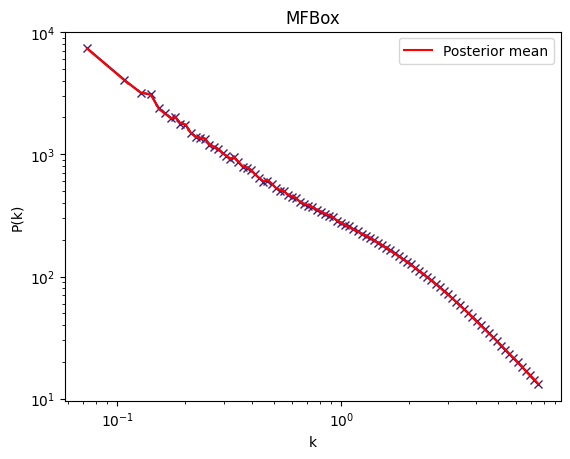

In [29]:
# plot the Pk comparison: GP predictions versus true Pk
test_i = 5

plt.title("MFBox")

plt.loglog(10**kf, 10 ** (Y_test[:, test_i]), marker="x")

plt.loglog(
    10**kf,
    10 ** (y_pred[test_i, :]),
    c="r",
    label="Posterior mean",
)
plt.fill_between(
    10**kf,
    10 ** (y_pred[test_i, :] - np.sqrt(var_pred[test_i, :])),
    10 ** (y_pred[test_i, :] + np.sqrt(var_pred[test_i, :])),
    color="r",
    alpha=0.2,
)


# plt.loglog(10**kf, 10 ** (Y_test[:, test_i] + Y_h_mean))

# plt.loglog(
#     10**kf,
#     10 ** (y_pred[test_i, :] + Y_h_mean),
#     c="r",
#     label="Posterior mean",
# )
# plt.fill_between(
#     10**kf,
#     10 ** (y_pred[test_i, :] - np.sqrt(var_pred[test_i, :]) + Y_h_mean),
#     10 ** (y_pred[test_i, :] + np.sqrt(var_pred[test_i, :]) + Y_h_mean),
#     color="r",
#     alpha=0.2,
# )


# plt.loglog(10**kf, 10 ** ((Y_test[:, test_i] + 1) * scalefactors))

# plt.loglog(
#     10**kf,
#     10 ** ((y_pred[test_i, :] + 1) * scalefactors),
#     c="r",
#     label="Posterior mean",
# )
# plt.fill_between(
#     10**kf,
#     10 ** ((y_pred[test_i, :] - np.sqrt(var_pred[test_i, :]) + 1) * scalefactors),
#     10 ** ((y_pred[test_i, :] + np.sqrt(var_pred[test_i, :]) + 1) * scalefactors),
#     color="r",
#     alpha=0.2,
# )

leg = plt.legend(loc="upper right")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"k")
plt.ylabel("P(k)")
plt.show()


Text(0.5, 0, 'k [h/cMpc]')

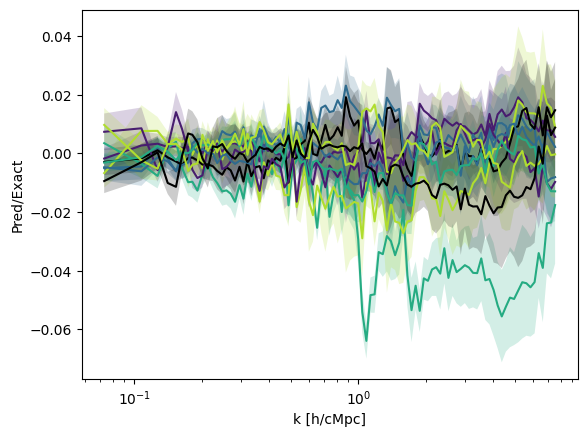

In [30]:
# plt.plot(10 ** (Y_test + Y_h_mean[:, None]) / 10 ** (mu_final + Y_h_mean[:, None]) - 1)

for i in range(Y_test.shape[1]):
    plt.semilogx(10**kf, 10 ** (Y_test[:, i]) / 10 ** (mu_final[:, i]) - 1)
    plt.fill_between(
        10**kf,
        10 ** (Y_test[:, i]) / 10 ** (mu_final[:, i] - np.sqrt(v_final[:, i])) - 1,
        10 ** (Y_test[:, i]) / 10 ** (mu_final[:, i] + np.sqrt(v_final[:, i])) - 1,
        alpha=0.2,
    )

plt.ylabel("Pred/Exact")
plt.xlabel("k [h/cMpc]")

# plt.plot(
#     10 ** ((Y_test + 1) * scalefactors[:, None])
#     / 10 ** ((mu_final + 1) * scalefactors[:, None])
#     - 1
# )


## Double check with LF predictions


In [31]:
l1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=X_l1,
    observation_index_points=X_l1,
    observations=Y_l1,
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

l1_mean = l1_gprm.mean()
l1_mean.shape


TensorShape([95, 60])

<tf.Tensor: shape=(95,), dtype=float64, numpy=
array([1.00015327, 1.00026112, 1.00075765, 1.00083325, 1.00077117,
       1.00046275, 1.0007425 , 1.00091492, 1.00140135, 1.00128659,
       1.00108279, 1.00079563, 1.00076913, 1.00127255, 1.001448  ,
       1.00145309, 1.00147062, 1.00118338, 1.00091008, 1.00096827,
       1.00111143, 1.00110039, 1.00088816, 1.00087419, 1.00108445,
       1.00126762, 1.00086011, 1.00107764, 1.00131033, 1.00113898,
       1.00106985, 1.00127793, 1.00139676, 1.00138508, 1.00172454,
       1.00190007, 1.0023017 , 1.00238151, 1.00337136, 1.00414537,
       1.00345411, 1.00333582, 1.00425979, 1.0052366 , 1.0045862 ,
       1.00313462, 1.00506811, 1.00540029, 1.00802441, 1.0057974 ,
       1.00579259, 1.00639698, 1.00669885, 1.00793045, 1.00825959,
       1.00675023, 1.00669824, 1.00544728, 1.00451557, 1.00507825,
       1.00437666, 1.00508483, 1.00421268, 1.00426582, 1.00431095,
       1.00530131, 1.00554308, 1.00510404, 1.00574702, 1.00659019,
       1.006686

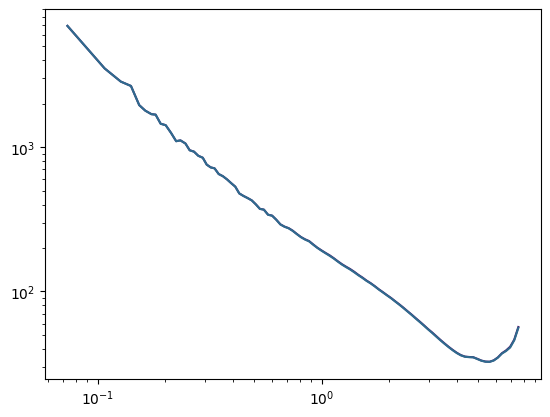

In [32]:
plt.loglog(10**kf, 10 ** (Y_l1[:, 0] + Y_l1_mean))
plt.loglog(10**kf, 10 ** (l1_mean[:, 0] + Y_l1_mean))

10 ** (Y_l1[:, 0] + Y_l1_mean) / 10 ** (l1_mean[:, 0] + Y_l1_mean)
